In [ ]:
import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64, img_as_ubyte
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr


In [ ]:
lenna_rgb_512x512 = io.imread('lenna.bmp')
lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')

RGB shape : (256, 256, 3)
Gray shape : (256, 256)


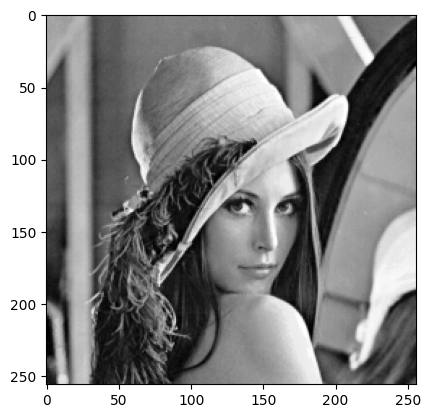

In [ ]:
plt.imshow(lenna_gray_256x256, cmap='gray')
print("RGB shape : {}\nGray shape : {}".format(lenna_rgb_256x256.shape, lenna_gray_256x256.shape))

In [ ]:
BlockTransform = namedtuple('BlockTransform', ['x', 'y', 'di', 'tr'])
FractalCompressionParams = namedtuple(
    'FractalCompressionParams', [
        'height',
        'width',
        'is_colored',
        'block_size',
        'spatial_scale',
        'intensity_scale',
        'stride'
    ]
)

In [ ]:
def derive_num_bits(length, stride):
    return np.ceil(np.log2(length / stride)).astype(int)
def is_colored(image):
    if len(image.shape) == 2:
        return False
    elif len(image.shape) == 3 and image.shape[-1] == 3:
        return True
    else:
        message = 'Invalid shape of the image: `{}`'
        raise ValueError(message.format(image.shape))
def find_block_transform(image, resized_image, x, y, block_size, stride):
    '''Find best transformation for given rank block.

    Parameters
    ----------
    image : np.array
        Source B/W image.

    resized_image: np.array
        Resized source image.

    x, y: int, int
        Coordinates of the rank block.

    block_size: int
        Size of rank block.

    stride: int
        Vertical and horizontal stride for domain block search.

    Returns
    -------
    best_transform: BlockTransform
        Best transformation.
    '''
    def affine(image, times, flip):
        if flip == 1:
            image = np.flip(image, 1)
        return np.rot90(image, times)

    def int_quantized(number):
        return np.int64(np.rint(255 * number))

    def float_quantized(number):
        return int_quantized(number) / 255

    rank_block = image[x:x+block_size, y:y+block_size]
    difference = np.inf
    best_transform = None

    N, M = resized_image.shape
    dims = block_size ** 2
    for i in range(0, N, stride):
        for j in range(0, M, stride):
            if i + block_size > N or j + block_size > M:
                continue
            domain_block = resized_image[i : i + block_size, j : j + block_size]
            domain_sum = np.sum(domain_block)
            rank_sum = np.sum(rank_block)
            domain_squared = np.sum(domain_block * domain_block)
            for flip in range(2):
                if flip:
                    domain_block = np.rot90(domain_block, 1)
                    domain_block = np.flip(domain_block, 1)
                for times in range(4):
                    domain_block = np.rot90(domain_block, np.min([times, 1]))
                    element_wise = np.sum(domain_block * rank_block)

                    denominator = dims * domain_squared - domain_sum ** 2
                    if denominator != 0:
                        scale = (dims * element_wise - domain_sum * rank_sum) / (dims * domain_squared - domain_sum ** 2)
                        scale = np.sign(scale) * min(1, np.abs(scale))
                        scale = float_quantized(scale)
                    else:
                        scale = 0
                    bias = ((rank_sum - scale * domain_sum) / dims)
                    bias = np.sign(bias) * min(1, np.abs(bias))
                    bias = float_quantized(bias)

                    assert (np.isscalar(scale) and np.isscalar(bias)), \
                    "scale type : {}, bias type : {}".format(scale, bias)

                    curr_diff = np.sum((rank_block - (domain_block * scale + bias)) ** 2)
                    if curr_diff < difference:
                        difference = curr_diff
                        scale_is_negative = np.int64(scale < 0)
                        bias_is_negative = np.int64(bias < 0)

                        scale = int_quantized(scale)
                        bias = int_quantized(bias)

                        best_transform = BlockTransform(i, j, times + flip * 4, (np.abs(scale), scale_is_negative,
                                                                                 np.abs(bias), bias_is_negative))
    return best_transform
def perform_transform(image, resized_image, transforms, block_size, Smax):
    for transform in transforms:
        x, y, tf, (scale, scale_is_neg, bias, bias_is_neg) = transform
        scale /= 2 ** self._scale_bits - 1
        bias /= 2 ** self._bias_bits - 1
        if scale_is_neg:
            scale *= -1
        if bias_is_neg:
            bias *= -1

        scale *= Smax

        domain_block = self._affine(resized_image[x:x+block_size, y:y+block_size], tf)
        rank_block = scale * domain_block + bias
        image[x:x+block_size, y:y+block_size] = rank_block
    return image
# GRADED CELL: BitBuffer

class BitBuffer:
    '''Class that provides storing and and reading integer numbers
    in continuous bytearray.

    Parameters
    ----------
    buffer : bytearray, optional (default=None)
        Input bytearray, for initialization.

    Attributes
    ----------
    _buffer : bytearray
        Bytearray that can contain any information.

    Examples
    --------
    >>> buffer = BitBuffer()
    >>> buffer.push(1, 1)
    >>> x = buffer.pop(1)
    >>> print(x)
    1
    >>> buffer.push(125, 18)
    >>> x = buffer.pop(18)
    >>> print(x)
    125
    >>> buffer.push(5, 3)
    >>> x = buffer.pop(3)
    >>> print(x)
    5

    >>> dy = transform.y // stride
    >>> buffer.push(dy, self._num_bits_ver)
    '''
    def __init__(self, buffer=None):
        self._buffer = buffer or bytearray()
        if buffer is None:
            self._buffer.append(0)
        self._push_index = 0
        self._push_bits = 8
        self.reset()

    def to_bytearray(self):
        '''Convert to bytearray.

        Returns
        -------
        buffer: bytearray
            Bytearray that contains all data.
        '''

        return self._buffer

    def push(self, x, n_bits):
        '''Push given integer to buffer.

        Parameters
        ----------
        x : int
            Input number.

        n_bits: int
            Number of bits for store input number,
            should be greater than log2(x).
        '''
        assert 2 ** n_bits > x, "n_bits : {}, x : {}".format(n_bits, x)

        forward_bin = list(map(lambda x : int(x), bin(x)[2:]))
        for _ in range(n_bits - len(forward_bin)):
            self._push(0)
        for bit in forward_bin:
            self._push(bit)

    def _push(self, bit):
        self._push_check()
        self._buffer[self._push_index] += 2 ** (self._push_bits - 1) * bit
        self._push_bits -= 1

    def _push_check(self):
        if self._push_bits == 0:
            self._buffer.append(0)
            self._push_index += 1
            self._push_bits = 8

    def pop(self, n_bits):
        '''Pop n_bits from buffer and transform it to a number.

        Parameters
        ----------
        n_bits: int
            Number of bits for pop from buffer.

        Returns
        -------
        x: int
            Extracted number.
        '''
        x = 0
        for _ in range(n_bits):
            has_bit = (self._buffer[self._pop_index] & (2 ** (self._pop_bits - 1))) != 0
            x <<= 1
            x |= has_bit
            self._pop_bits -= 1
            self._pop_check()
        return x

    def reset(self):
        self._pop_index = 0
        self._pop_bits = 8

    def _pop_check(self):
        if self._pop_bits == 0:
            self._pop_index += 1
            self._pop_bits = 8

    def __getitem__(self, index):
        return self._buffer[index]

    def __str__(self):
        return ' '.join([bin(self._buffer[i])[2:] for i in range(len(self._buffer))])

    def __len__(self):
        return len(self._buffer)
# GRADED CELL: FractalCompressor

class FractalCompressor:
    '''Class that performs fractal compression/decompression of images.

    Attributes
    ----------
    _num_bits_ver : int
        Number of bits for store VERTICAL OFFSET for each transformation.

    _num_bits_hor : int
        Number of bits for store HORIZONTAL OFFSET for each transformation.

    _num_bits_pix : int
        Number of bits for store INTENSITY OFFSET for each transformation.

    _num_bits_tfm : int
        Number of bits for store TRANFORMATION INDEX for each transformation.

    Examples
    --------
    >>> comp = FractalCompressor()
    >>> compressed_image = comp.compress(image, block_size=8, stride=2)
    >>> decompressed_image = comp.decompress(compressed_image, num_iters=9)
    >>> yet_another_compressed_image = comp.compress(image, 8, 4, 0.5, 0.7)
    >>> yet_another_decompressed_image = comp.compress(yet_another_compressed_image, 5)
    '''

    def __init__(self, quadtree=True):
        self._num_bits_tfm = 3
        self._threshold_bits = 12
        self.min_block_size_reached = np.inf

        self._scale_bits = 5
        self._bias_bits = 7

        self._family_container = {}
        self.quadtree = quadtree
        self._stride = 2
        self._depth_stride = {64 : 32, 32 : 16, 16 : 8, 8 : 4, 4 : 4}
        self._threshold_shift = 50

    def _affine(self, image, rotate_flip):
        times, flip = rotate_flip % 4, rotate_flip // 4
        if flip == 1:
            image = np.flip(image, 1)
        return np.rot90(image, times)

    def _add_header(self, buffer, params):
        '''Store header in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        params: FractalCompressionParams
            Parameters that should be stored in buffer.

        Note
        ----
        This method must be consistent with `_read_header`.
        '''

        # YOUR CODE HERE
        height, width, colored, block_size, _, _, stride = params

        buffer.push(height, 9)
        buffer.push(width, 9)
        buffer.push(colored, 1)
        buffer.push(block_size, 7)
        buffer.push(stride, 5)

    def _read_header(self, buffer):
        '''Read header from buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted parameters.

        Note
        ----
        This method must be consistent with `_add_header`.
        '''
        height = buffer.pop(9)
        width = buffer.pop(9)
        is_colored = buffer.pop(1)
        block_size = buffer.pop(7)
        stride = buffer.pop(5)

        params = FractalCompressionParams(
            height,
            width,
            is_colored,
            block_size,
            _,
            _,
            stride
        )
        return params

    def _add_transform(self, buffer, transform):
        '''Store block transformation in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        transform: BlockTransform

        Note
        ----
        This method must be consistent with `_read_transform`.
        '''
        x, y, tf, (scale, scale_is_negative, bias, bias_is_negative) = transform
        buffer.push(x, 8)
        buffer.push(y, 8)
        buffer.push(tf, self._num_bits_tfm)
        buffer.push(scale, self._scale_bits)
        buffer.push(scale_is_negative, 1)
        buffer.push(bias, self._bias_bits)
        buffer.push(bias_is_negative, 1)

    def _read_transform(self, buffer):
        '''Read block transformation from buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        transform: BlockTransform
            Extracted block transformation.

        Note
        ----
        This method must be consistent with `_add_to_buffer`.
        '''
        x = buffer.pop(8)
        y = buffer.pop(8)
        tf = buffer.pop(self._num_bits_tfm)
        scale = buffer.pop(self._scale_bits)
        scale_is_negative = buffer.pop(1)
        bias = buffer.pop(self._bias_bits)
        bias_is_negative = buffer.pop(1)
        transform = BlockTransform(x, y, tf, (scale, scale_is_negative, bias, bias_is_negative))
        return transform

    def _ifs2buf(self, params, transformations):
        '''Store compression parameters and IFS in buffer.

        Parameters
        ----------
        params: FractalCompressionParams
            Parameters of the compression.

        transformations: list of BlockTransform's
            Given IFS.

        Returns
        -------
        buffer: BitBuffer

        Note
        ----
        This method must be consistent with `_buf2ifs`.
        '''

        buffer = BitBuffer()
        self._add_header(buffer, params)
        return self._tf2buf(buffer, transformations)

    def _tf2buf(self, buffer, transforms):
        for t in transforms:
            self._add_transform(buffer, t)
        return buffer

    def _buf2ifs(self, buffer):
        '''Store compression parameters and IFS in buffer.

        Parameters
        ----------
        buffer: BitBuffer

        Returns
        -------
        params: FractalCompressionParams
            Extracted compression parameters.

        transforms: list of BlockTransform's
            Extracted IFS.

        Note
        ----
        This method must be consistent with `_ifs2buf`.
        '''

        params = self._read_header(buffer)
        num_transforms = int(params.height * params.width / params.block_size ** 2)
        transforms = [
            self._read_transform(buffer, params.stride)
            for _ in range(num_transforms)
        ]

        return params, transforms

    def _read_transforms(self, buffer, height, width, block_size):
        num_transforms = int(height * width / block_size ** 2)
        transforms = [
            self._read_transform(buffer)
            for _ in range(num_transforms)
        ]
        return transforms

    def _quadtree_read_transform(self, buffer):
        return self._read_transform(buffer)

    def _quadtree_add_transform(self, buffer, transform):
        self._add_transform(buffer, transform)

    def _get_id(self, block, block_size):
        block_size = block_size // 2
        sum1 = np.sum(block[: block_size, : block_size])
        sum2 = np.sum(block[: block_size, block_size : 2 * block_size])
        sum3 = np.sum(block[block_size : 2 * block_size, block_size : 2 * block_size])
        sum4 = np.sum(block[block_size : 2 * block_size, : block_size])
        l = [(sum1, 0), (sum2, 1), (sum3, 2), (sum4, 3)]
        # So, the id is some permutation of {0, 1, 2, 3} represented as a string
        # for example, {2, 3, 1, 0} gives "2310" and {0, 1, 2, 3} gives "0123" as an id.
        block_id = "".join(str(x[1]) for x in sorted(l))
        if (len(block_id) != 4):
            assert False, "block_id len = {}, d : {}".format(len(block_id), l)
        return block_id

    def _determine_family(self, resized_image, block_size):
        stride = self._depth_stride[block_size]

        if is_colored(resized_image):
            H, W, _ = resized_image.shape
        else:
            H, W = resized_image.shape
        xs = np.arange(0, H, stride)
        ys = np.arange(0, W, stride)
        for x, y in itertools.product(xs, ys):
            for tf in range(8):
                domain_id = self._get_id(self._affine(resized_image[x : x + block_size, y : y + block_size], tf), block_size)
                # Encapsulation violated, but who cares
                self._family_container.update({(x, y, block_size, tf) : domain_id})

    def _quadtree_apply_one_transform(self, image, resized_image, buffer, block_size, x, y):
        rank_block = image[x : x + block_size, y : y + block_size]

        recursive_dig = buffer.pop(1)
        if recursive_dig and block_size  > 4:
            block_size = block_size // 2
            rank_block[: block_size, : block_size] = \
                self._quadtree_apply_one_transform(image, resized_image, buffer, block_size, x, y)

            rank_block[: block_size, block_size : 2 * block_size] = \
                self._quadtree_apply_one_transform(image, resized_image, buffer, block_size, x, y + block_size)

            rank_block[block_size : 2 * block_size, block_size : 2 * block_size] = \
                self._quadtree_apply_one_transform(image, resized_image, buffer, block_size, x + block_size, y + block_size)

            rank_block[block_size : 2 * block_size, : block_size] = \
                self._quadtree_apply_one_transform(image, resized_image, buffer, block_size, x + block_size, y)
            return rank_block
        transform = self._quadtree_read_transform(buffer)
        domain_x, domain_y, rotate_flip, (scale, scale_is_neg, bias, bias_is_neg) = transform
        scale /= 2 ** self._scale_bits - 1
        bias /= 2 ** self._bias_bits - 1
        if bias_is_neg:
            bias *= -1
        if scale_is_neg:
            scale *= -1
        rank_block = \
            scale * self._affine(resized_image[domain_x : domain_x + block_size, domain_y : domain_y + block_size], \
                                 rotate_flip) + bias
        return rank_block

    def _quadtree_apply_transforms(self, image, resized_image, buffer, block_size=32):
        N, M = image.shape
        xs = range(0, N, block_size)
        ys = range(0, M, block_size)
        for x, y in itertools.product(xs, ys):
            image[x : x + block_size, y : y + block_size] = \
                    self._quadtree_apply_one_transform(image, resized_image, buffer, block_size, x, y)
        return image

    def _float_quantize(self, number, bits):
        return self._int_quantize(number, bits) / (2 ** bits - 1)

    def _int_quantize(self, number, bits):
        return np.int64(np.rint((2 ** bits - 1) * number))

    def _quadtree_find_rank_transform(self, image, resized_image, x, y, block_size):
        stride = self._depth_stride[block_size]

        rank_block = image[x : x + block_size, y : y + block_size]
        rank_block_id = self._get_id(rank_block, block_size)
        difference = np.inf
        best_transform = None

        H, W = resized_image.shape
        dims = block_size ** 2

        xs = np.arange(0, H, stride)
        ys = np.arange(0, W, stride)
        for x_domain in xs:
            for y_domain in ys:
                if x_domain + block_size > H or y_domain + block_size > W:
                    continue

                match_any = False
                for tf in range(8):
                    match_any |= rank_block_id == self._family_container[(x_domain, y_domain, block_size, tf)] or \
                            rank_block_id == \
                                    self._family_container[(x_domain, y_domain, block_size, tf)][::-1]
                if not match_any:
                    continue

                domain_block = resized_image[x_domain : x_domain + block_size, y_domain : y_domain + block_size]
                rank_sum = np.sum(rank_block)
                rank_squared = np.sum(rank_block * rank_block)

                domain_sum = np.sum(domain_block)
                domain_squared = np.sum(domain_block * domain_block)
                for flip in range(2):
                    for times in range(4):
                        if rank_block_id != self._family_container[(x_domain, y_domain, block_size, 4 * flip + times)] and \
                            rank_block_id != \
                                    self._family_container[(x_domain, y_domain, block_size, 4 * flip + times)][::-1]:
                            continue
                        domain_block = self._affine(domain_block, 4 * flip + times)
                        element_wise = np.sum(domain_block * rank_block)

                        denominator = dims * domain_squared - domain_sum ** 2
                        if np.abs(denominator) > 1e-8:
                            scale = (dims * element_wise - domain_sum * rank_sum) / denominator
                            scale = np.sign(scale) * min(1, np.abs(scale))
                            scale = self._float_quantize(scale, self._scale_bits)
                        else:
                            scale = 0
                        bias = (rank_sum - scale * domain_sum) / dims
                        bias = np.sign(bias) * min(1, np.abs(bias))
                        bias = self._float_quantize(bias, self._bias_bits)


#                         curr_diff = scale * (scale * domain_squared + 2 * bias * domain_sum - 2 * element_wise) + bias * (dims * bias - 2 * rank_sum) + rank_squared
                        curr_diff = np.sum((rank_block - (domain_block * scale + bias)) ** 2)
                        if curr_diff < difference:
                            difference = curr_diff
                            scale_is_negative = np.int64(scale < 0)
                            bias_is_negative = np.int64(bias < 0)

                            scale = self._int_quantize(scale, self._scale_bits)
                            bias = self._int_quantize(bias, self._bias_bits)

                            best_transform = BlockTransform(x_domain, y_domain, times + flip * 4,
                                                            (np.abs(scale), scale_is_negative, np.abs(bias), bias_is_negative))
        if best_transform is None:
            print("Transform wasn't found, block_size : {}".format(block_size))
            print(Counter(self._family_container.values()))
            print(len(Counter(self._family_container.values())))
            # Work around that, I guess
            assert False
        return best_transform, difference


    def _quadtree_find_tf(self, buffer, image, resized_image, x, y, block_size, threshold):
        # ToDo : write custom function
        transform, loss = self._quadtree_find_rank_transform(image, resized_image, x, y, block_size)
        loss /= block_size ** 2
        loss = np.sqrt(loss)
        self.min_block_size_reached = min(self.min_block_size_reached, block_size)
        new_threshold = threshold
        if loss > threshold and block_size > 4:
            block_size = block_size // 2
            buffer.push(1, 1)
            self._quadtree_find_tf(buffer, image, resized_image, x, y, block_size, threshold)
            self._quadtree_find_tf(buffer, image, resized_image, x, y + block_size, block_size, threshold)
            self._quadtree_find_tf(buffer, image, resized_image, x + block_size, y  + block_size, block_size, threshold)
            self._quadtree_find_tf(buffer, image, resized_image, x + block_size, y, block_size, threshold)
            return
        buffer.push(0, 1)
        self._quadtree_add_transform(buffer, transform)

    def _quadtree_add_header(self, buffer, params):
        (height, width, colored, block_size, threshold) = params
        buffer.push(height, 9)
        buffer.push(width, 9)
        buffer.push(colored, 1)
        buffer.push(block_size, 7)
        buffer.push(threshold, self._threshold_bits)

    def _quadtree_read_header(self, buffer):
        height = buffer.pop(9)
        width = buffer.pop(9)
        colored = buffer.pop(1)
        block_size = buffer.pop(7)
        threshold = buffer.pop(self._threshold_bits)
        return (height, width, colored, block_size, threshold)

    def _quadtree_decompress(self, byte_array, num_iters=10):
        buffer = BitBuffer(byte_array)
        (height, width, colored, block_size, threshold) = self._quadtree_read_header(buffer)

        if not colored:
            image = img_as_float64(np.ones((height, width)))
            for iteration in range(num_iters):
                resized_image = resize(image, (height // 2, width // 2))
                image = self._quadtree_apply_transforms(image, resized_image, buffer, block_size=block_size)
                buffer.reset()
                self._quadtree_read_header(buffer)
        else:
            image = img_as_float64(np.ones((height, width, 3)))
            buffer.reset()
            for iteration in range(num_iters):
                buffer.reset()
                self._quadtree_read_header(buffer)
                for channel in range(3):
                    resized_image = resize(image[:, :, channel], (height // 2, width // 2))
                    image[:, :, channel] = self._quadtree_apply_transforms(image[:, :, channel], \
                                                                           resized_image, buffer, block_size=block_size)
            image = yuv2rgb(image)
        image = np.clip(image, -1, 1)
        return img_as_ubyte(image)

    def _quadtree_compress(self, image, block_size=32, threshold=63):
        colored = is_colored(image)
        if colored:
            H, W, _ = image.shape
        else:
            H, W = image.shape
        xs = range(0, H, block_size)
        ys = range(0, W, block_size)

        source_image = img_as_float64(image)

        buffer = BitBuffer()

        params = (H, W, colored, block_size, threshold)
        self._quadtree_add_header(buffer, params)
        threshold /= 2 ** self._threshold_bits
        if not colored:
            resized_image = resize(source_image, (H // 2, W // 2))
            for t_block_size in [32, 16, 8, 4]:
                self._determine_family(resized_image, t_block_size)
            for x, y in tqdm(itertools.product(xs, ys), total = len(xs) * len(ys)):
                self._quadtree_find_tf(buffer, source_image, resized_image,
                                       x, y, block_size, threshold)
        else:
            source_image = rgb2yuv(source_image)
            resized_image = resize(source_image, (H // 2, W // 2))
            for channel in range(3):
                if channel != 0:
                    new_threshold = threshold + self._threshold_shift
                else:
                    new_threshold = threshold

                for t_block_size in [32, 16, 8, 4]:
                    self._determine_family(resized_image[:, :, channel], t_block_size)
                for x, y in tqdm(itertools.product(xs, ys), total = len(xs) * len(ys)):
                    self._quadtree_find_tf(buffer, source_image[:, :, channel], resized_image[:, :, channel],
                                           x, y, block_size, new_threshold)
                self._family_container.clear()
        print("Min block size reached : {}".format(self.min_block_size_reached))
        return buffer.to_bytearray()

    def decompress(self, byte_array, num_iters=10, Smax=1.0):
      '''Decompress input image

      Parameters
      ----------
      byte_array: bytearray
          Compressed image.

      num_iters: int, optional (default=10)
          Number of iterations to perform IFS.

      Smax: float, optional (default=1.0)
          Scale factor for decoding steps.

      Returns
      -------
      image: np.array
          Decompressed image.

      Note
      ----
      This method must be consistent with `compress`.
      '''
      if self.quadtree:
          return self._quadtree_decompress(byte_array, num_iters=num_iters, Smax=Smax)

      bb = BitBuffer(byte_array)
      params = self._read_header(bb)
      height, width, colored, block_size, _, _, stride = params

      if not colored:
          image = img_as_float64(np.zeros((height, width)))  # Initial image is black

          transforms = self._read_transforms(bb, height, width, block_size)
          new_shape = (width // 2, height // 2)
          for _ in range(num_iters):
              resized_image = resize(image, new_shape)
              image = perform_transform(image, resized_image, transforms, block_size, Smax)
      else:
          image = img_as_float64(np.zeros((height, width, 3)))  # Initial image is black

          for channel in range(3):
              transforms = self._read_transforms(bb, height, width, block_size)
              new_shape = (width // 2, height // 2)
              for _ in range(num_iters):
                  resized_image = resize(image[:, :, channel], new_shape)
                  image[:, :, channel] = perform_transform(image[:, :, channel], resized_image, transforms, block_size, Smax)
          image = yuv2rgb(image)
      return img_as_ubyte(image)


    def compress(self, image, block_size=8, stride=1, threshold=None):
        '''Compress input image

        Parameters
        ----------
        image : np.array
            Source image.

        block_size: int, optional (default=8)
            Size of rank block.

        stride: int, optional (default=1)
            Vertical and horizontal stride for domain block search.

        spatial_scale : float, optional (default=0.5)
            ({rank block size} / {domain block size}) ratio, must be <1.

        intensity_scale : float, optional (default=0.75)
            Reduce coefficient for image intensity.

        Returns
        -------
        byte_array: bytearray
            Compressed image.

        Note
        ----
        This method must be consistent with `decompress`.
        '''
        self.min_block_size_reached = np.inf
        assert threshold is not None, "Please, specify threshold first, current threshold is {}".format(threshold)
        if self.quadtree:
            return self._quadtree_compress(image, block_size=block_size, threshold=threshold)

        colored = is_colored(image)
        image = img_as_float64(image)
        if colored:
            N, M, _ = image.shape
        else:
            N, M = image.shape

        xs = range(0, N, block_size)
        ys = range(0, M, block_size)
        transformations = []
        params = FractalCompressionParams(
            N,
            M,
            colored,
            block_size,
            None,
            None,
            stride
        )

        if not colored:
            source_image = image
            resized_image = resize(image, \
                                  (N // 2, M // 2))
            for x, y in tqdm(itertools.product(xs, ys), total=len(xs)*len(ys)):
                transform = find_block_transform(
                    source_image, resized_image,
                    x, y, block_size, stride
                )
                transformations.append(transform)
            buffer = self._ifs2buf(params, transformations)
        else:
            image = rgb2yuv(image)
            buffer = BitBuffer()
            self._add_header(buffer, params)
            for channel in range(3):
                source_image = image[:, :, channel]
                resized_image = resize(image[:, :, channel], \
                                      (N // 2, M // 2))
                for x, y in tqdm(itertools.product(xs, ys), total=len(xs)*len(ys)):
                    transform = find_block_transform(
                        source_image, resized_image,
                        x, y, block_size, stride
                    )
                    transformations.append(transform)
                self._tf2buf(buffer, transformations)
                transformations.clear()
        return buffer.to_bytearray()

    def compress2(self, image, quality=50):
        '''Compress input image

        Parameters
        ----------
        image : np.array
            Source image.

        quality: int, optional (default=50)
            Quality of image compression

        Returns
        -------
        byte_array: bytearray
            Compressed image.

        Note
        ----
        This method must be consistent with `decompress`.
        '''
        if quality == 0:
            return self.compress(image, block_size=32, stride=666, threshold=1500)
        elif quality == 20:
            return self.compress(image, block_size=32, stride=666, threshold=400)
        elif quality == 40:
            return self.compress(image, block_size=32, stride=666, threshold=275)
        elif quality == 60:
            return self.compress(image, block_size=32, stride=666, threshold=200)
        elif quality == 80:
            return self.compress(image, block_size=32, stride=666, threshold=150)
        elif quality == 100:
            return self.compress(image, block_size=32, stride=666, threshold=100)
def compute_psnr(original, decompressed):
    return peak_signal_noise_ratio(original, decompressed)
def plot_psnr_vs_steps(byte_array, original_image, max_steps=10, smax_values=[0.5, 1.0, 2.0, 4.0]):
    psnr_results = {smax: [] for smax in smax_values}

    for smax in smax_values:
        for steps in range(1, max_steps + 1):
            decompressed_image = self.decompress(byte_array, num_iters=steps, Smax=smax)
            psnr_value = compute_psnr(original_image, decompressed_image)
            psnr_results[smax].append(psnr_value)

    plt.figure(figsize=(10, 6))
    for smax, psnr_values in psnr_results.items():
        plt.plot(range(1, max_steps + 1), psnr_values, label=f'Smax={smax}')

    plt.xlabel('Decoding Steps')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs. Decoding Steps for Different Smax Values')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
comp = FractalCompressor()
def load_image(image_name):
    img = io.imread(image_name)
    img = resize(img, (256, 256))
    return img
boat = load_image('BoatsColor.bmp')
print(boat.shape)
gray_boat = rgb2gray(boat)


(256, 256, 3)


In [ ]:
result_16x4 = comp.compress(lenna_gray_256x256, block_size=32, stride=666, threshold=300)

100%|██████████| 64/64 [00:49<00:00,  1.28it/s]

Min block size reached : 4


In [ ]:
print(len(result_16x4))

3032


In [ ]:
n_iters = [1, 2, 3, 4, 20]

imgs = [comp.decompress(result_16x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(20, 8))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')
plt.show()

TypeError: FractalCompressor._quadtree_decompress() got an unexpected keyword argument 'Smax'

100%|██████████| 64/64 [00:00<00:00, 232.98it/s]


Min block size reached : 4
Image size : 16271


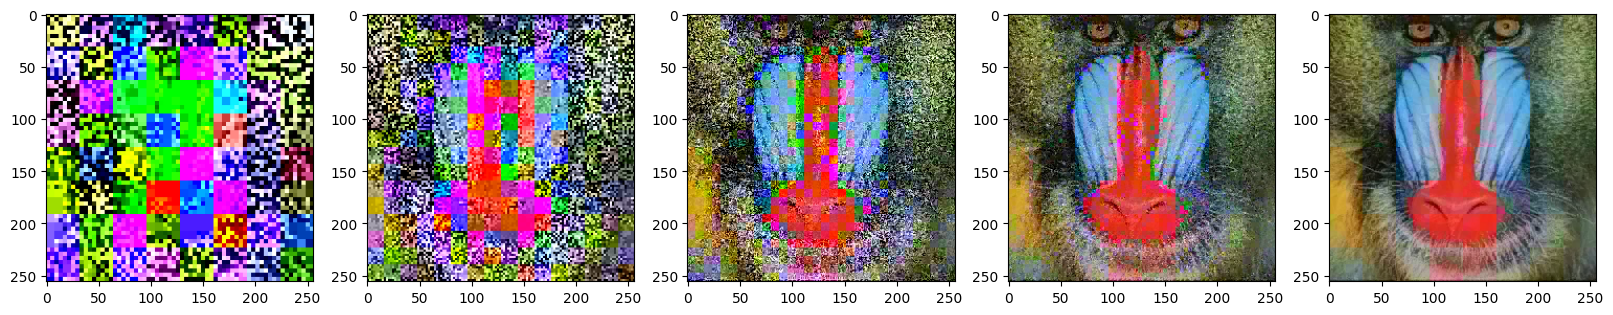

In [ ]:
def test_image_local(image_name, compressor, colored=True, block_size=32, threshold=1500):
    image = load_image(image_name)
    if not colored:
        image = rgb2gray(image)
    byte_array = compressor.compress(image, block_size=block_size, stride=666, threshold=threshold)
    print("Image size : {}".format(len(byte_array)))
    n_iters = [1, 2, 3, 4, 20]
    imgs = [compressor.decompress(byte_array, n) for n in n_iters]
    _, axs = plt.subplots(ncols=len(imgs), figsize=(20, 8))
    for index in range(len(imgs)):
        axs[index].imshow(imgs[index], cmap='gray')
    plt.show()
images = {'Baboon' : 'baboon.bmp', 'Lenna' : 'lenna.bmp', 'Boat' : 'BoatsColor.bmp'}
test_image_local(images['Baboon'], comp, colored=True, block_size=32, threshold=100)

In [ ]:
result_16x2 = comp.compress(lenna_gray_256x256, block_size=16, stride=2, threshold=50)

100%|██████████| 256/256 [04:10<00:00,  1.02it/s]

Min block size reached : 4


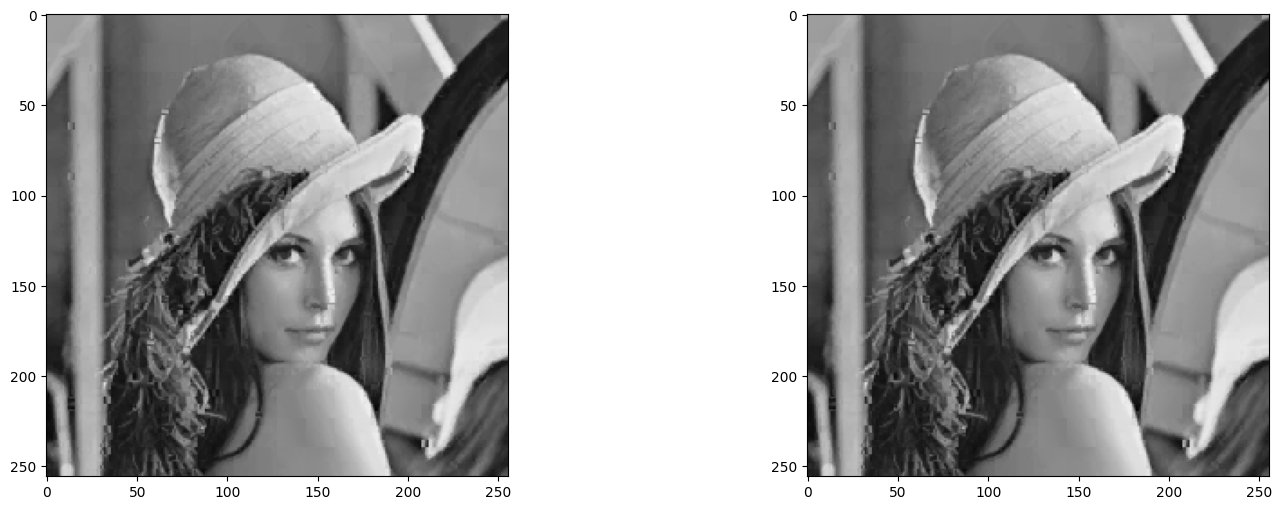

In [ ]:
n_iters = [8, 16]

imgs = [comp.decompress(result_16x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [ ]:
result_8x4 = comp.compress(lenna_rgb_256x256, block_size=8, stride=8,threshold=50)

100%|██████████| 1024/1024 [01:08<00:00, 15.00it/s]

Min block size reached : 4


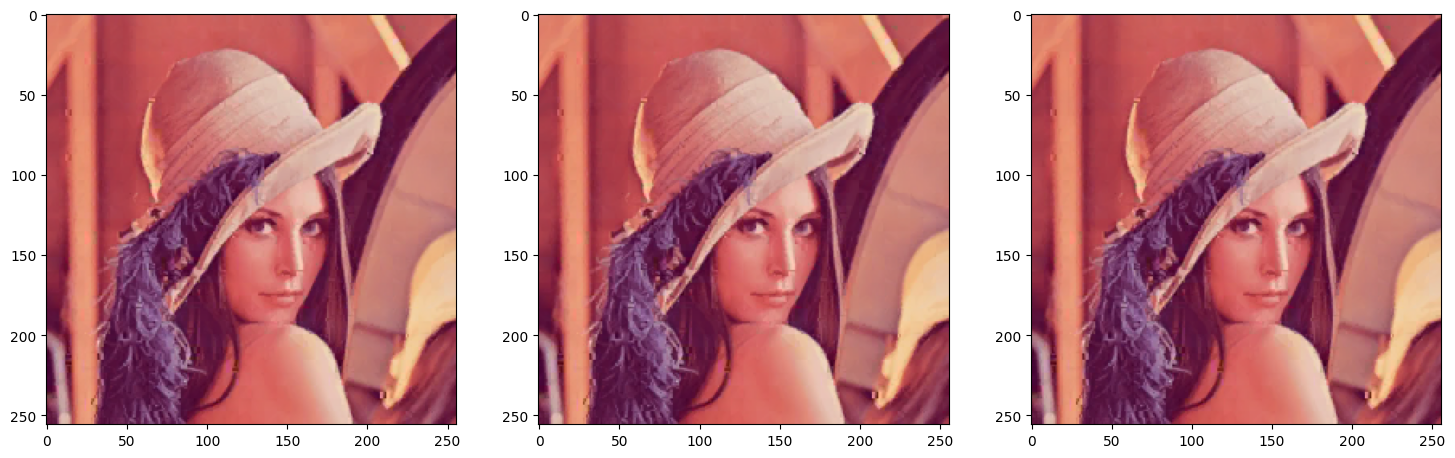

In [ ]:
n_iters = [8, 16, 32]

imgs = [comp.decompress(result_8x4, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(18, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

In [ ]:
result_8x2 = comp.compress(lenna_rgb_256x256, block_size=4, stride=31,threshold=300)

100%|██████████| 4096/4096 [04:40<00:00, 14.61it/s]

Min block size reached : 4


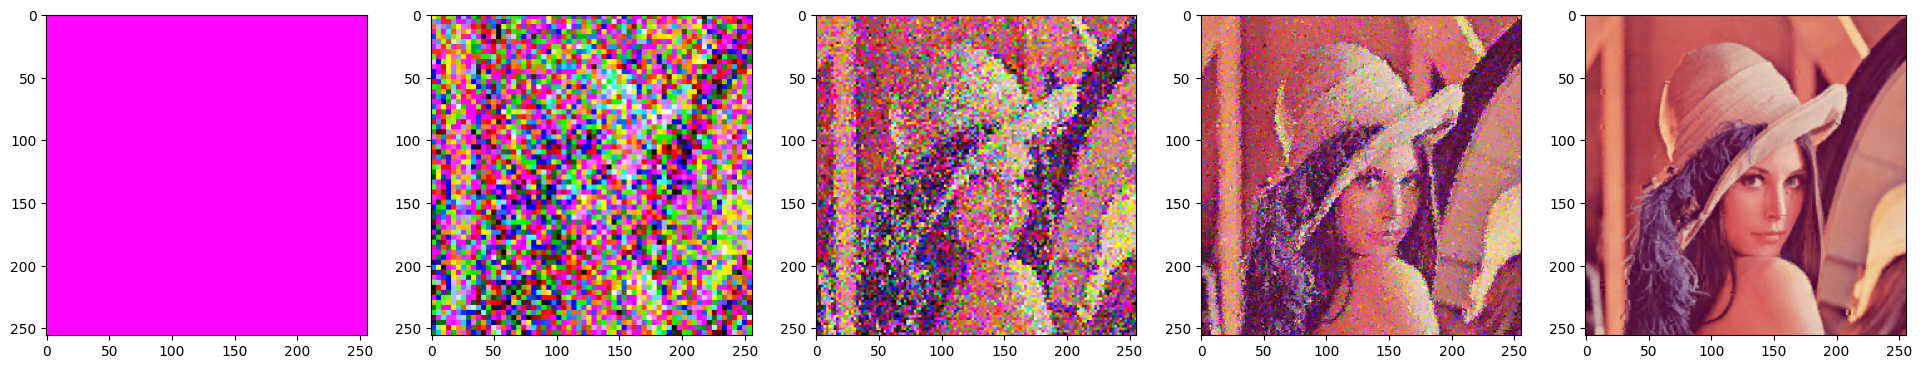

In [ ]:
n_iters = [0, 1, 2, 3, 20]

imgs = [comp.decompress(result_8x2, n) for n in n_iters]
_, axs = plt.subplots(ncols=len(imgs), figsize=(24, 6))
for index in range(len(imgs)):
    axs[index].imshow(imgs[index], cmap='gray')

plt.show()

100%|██████████| 64/64 [00:00<00:00, 237.66it/s]


Min block size reached : 32


100%|██████████| 64/64 [00:00<00:00, 149.50it/s]


Min block size reached : 4


100%|██████████| 64/64 [00:00<00:00, 133.12it/s]


Min block size reached : 4


100%|██████████| 64/64 [00:00<00:00, 231.66it/s]


Min block size reached : 4


100%|██████████| 64/64 [00:00<00:00, 215.58it/s]


Min block size reached : 4


100%|██████████| 64/64 [00:00<00:00, 147.09it/s]


Min block size reached : 4


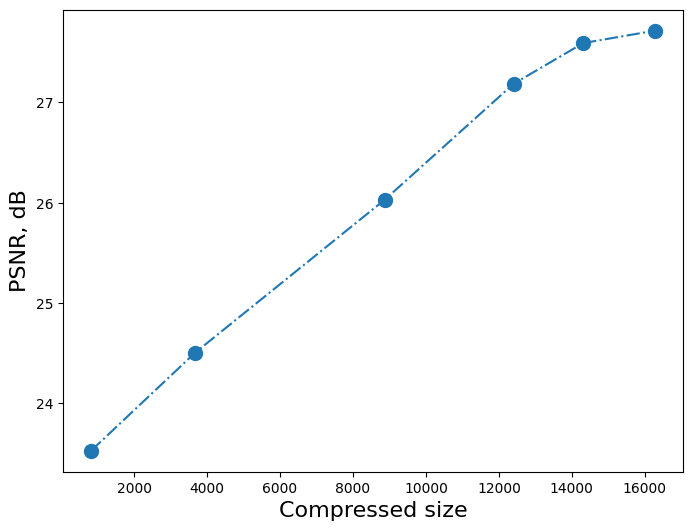

In [ ]:
def weighted_psnr(ref, img):
    assert ref.shape == img.shape, "Shape mismatch"
    if is_colored(img):
        ref_yuv = rgb2yuv(ref)
        img_yuv = rgb2yuv(img)

        return (4 * psnr(ref_yuv[..., 0], img_yuv[..., 0]) +
                    psnr(ref_yuv[..., 1], img_yuv[..., 1]) +
                    psnr(ref_yuv[..., 2], img_yuv[..., 2])
               ) / 6
    else:
        return psnr(ref, img)
quality = [0, 20, 40, 60, 80, 100]

def test_image(img):
    compressed_images = [comp.compress2(img, quality=q) for q in quality]
    decompressed_images = [comp.decompress(compressed) for compressed in compressed_images]
    compression_rates = np.array([len(compressed) for compressed in compressed_images])
    psnrs = [weighted_psnr(img, decompressed) for decompressed in decompressed_images]
    return compression_rates, psnrs
def test_and_plot_collection(collection, f_names):
    for image, fname in zip(collection, f_names):
        fig, ax = plt.subplots(figsize=(8, 6))
        compression_rates, psnrs = test_image(image)
        ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')
        ax.set_xlabel('Compressed size', fontsize=16)
        ax.set_ylabel('PSNR, dB', fontsize=16)
        plt.savefig(fname + '.png')
fname = 'baboon.bmp'
test_and_plot_collection([load_image(fname)], fname)